<a href="https://colab.research.google.com/github/its-parmiss/few-shot-learning--Deep-learning-project/blob/main/The_Final_Project_for_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms, models
import numpy as np
from numpy.random import RandomState
import pandas as pd
import os
import scipy as sp
import scipy.stats
import random
from torch.utils.data import random_split, DataLoader
from skimage.transform import warp
from scipy.ndimage import map_coordinates, gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import math

In [ ]:
!pip install scikit-image


# **Challenge 1**

In [ ]:

# Define the model
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 2),
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = (target == classes[1]).long()  
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = (target == classes[1]).long() 
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() 
            pred = output.max(1, keepdim=True)[1]  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

from torch.utils.data import Subset, Dataset

class AugmentedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y



  

In [ ]:
from PIL import Image
def elastic_deformation(image, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(shape[0], shape[1]) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(shape[0], shape[1]) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.empty((2, shape[0], shape[1]), dtype=np.float32)
    indices[0] = y + dy
    indices[1] = x + dx

    deformed_image = np.empty_like(image)
    for channel in range(shape[2]):
        deformed_image[:, :, channel] = map_coordinates(image[:, :, channel], indices, order=1, mode='reflect').reshape(shape[0], shape[1])
    return deformed_image




def diffeomorphic_augmentation(x):
    image = np.array(x)
    deformed_image = elastic_deformation(image, alpha=30, sigma=5)
    return Image.fromarray(deformed_image)


In [ ]:
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
transform_train = transforms.Compose([
    transforms.Lambda(diffeomorphic_augmentation),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same


# Extensive hyperparameter search to get optimal hyperparamethers

In [ ]:
class simpleCNN(nn.Module):
    def __init__(self, d1, d2, d3, d4,dropout_rate):
        super(simpleCNN, self).__init__()
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.d4=d4
        self.dropout_rate=dropout_rate
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, d1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(d2, d3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(d3 * 4 * 4, d4),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc2 = nn.Linear(d4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


we get a list of datasets so the data we are experimenting on is fixed. 

In [ ]:



use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
accs = []
#do this so we can test different hyperparameters on same dataset
dataset_list=[]
for seed in range(1, 5):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))

  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

  tuple1=(indx_train,indx_val)
  dataset_list.append(tuple1)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
d1_list = [ 32, 64,128]
d2_list =[ 32, 64,128]
d3_list = [ 32, 64,128]
d4_list = [ 32, 64,128]
dropout_list = [ 0.5]
results=[]
for d1 in d1_list:
    for d2 in d2_list:
        for d3 in d3_list:
          for d4 in d4_list:
              for dropout in dropout_list:
                  print(f"d1={d1}, d2={d2}, d3={d3}, d4={d4}, dropout={dropout}")
                  accs=[]
                  for d in dataset_list: 
                    indx_train,indx_val = d

                    train_data = Subset(cifar_data, indx_train)
                    val_data = Subset(cifar_data_val, indx_val)

                    # print('Num Samples For Training %d Num Samples For Val %d' % (train_data.indices.shape[0], val_data.indices.shape[0]))

                    train_loader = torch.utils.data.DataLoader(train_data,
                                                              batch_size=128,
                                                              shuffle=True)

                    val_loader = torch.utils.data.DataLoader(val_data,
                                                            batch_size=128,
                                                            shuffle=False)

                    model = simpleCNN(d1=d1, d2=d2, d3=d3, d4=d4,dropout_rate=dropout)
                    model.to(device)

                    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

                    for epoch in range(100):
                        train(model, device, train_loader, optimizer, epoch, display=False)
                    acc=test(model, device, val_loader)
                    accs.append(acc)
                  
                  accs = np.array(accs)
                  print('Acc over 5 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
                  dic={"d1":d1, "d2":d2, "d3":d3, "d4":d4, "accuracy mean":accs.mean(), "accuracy.std": accs.std()}
                  results.append(dic)


d1=32, d2=32, d3=32, d4=32, dropout=0.5


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Acc over 5 instances: 64.00 +- 7.02
d1=32, d2=32, d3=32, d4=64, dropout=0.5
Acc over 5 instances: 66.62 +- 11.98
d1=32, d2=32, d3=32, d4=128, dropout=0.5
Acc over 5 instances: 72.69 +- 7.28
d1=32, d2=32, d3=64, d4=32, dropout=0.5
Acc over 5 instances: 59.50 +- 6.63
d1=32, d2=32, d3=64, d4=64, dropout=0.5
Acc over 5 instances: 65.75 +- 3.65
d1=32, d2=32, d3=64, d4=128, dropout=0.5
Acc over 5 instances: 68.25 +- 1.16
d1=32, d2=32, d3=128, d4=32, dropout=0.5
Acc over 5 instances: 63.31 +- 6.61
d1=32, d2=32, d3=128, d4=64, dropout=0.5
Acc over 5 instances: 67.50 +- 3.64
d1=32, d2=32, d3=128, d4=128, dropout=0.5
Acc over 5 instances: 73.25 +- 5.14
d1=32, d2=64, d3=32, d4=32, dropout=0.5
Acc over 5 instances: 60.19 +- 11.61
d1=32, d2=64, d3=32, d4=64, dropout=0.5
Acc over 5 instances: 67.00 +- 5.51
d1=32, d2=64, d3=32, d4=128, dropout=0.5
Acc over 5 instances: 68.00 +- 6.69
d1=32, d2=64, d3=64, d4=32, dropout=0.5
Acc over 5 instances: 64.06 +- 4.68
d1=32, d2=64, d3=64, d4=64, dropout=0.5
Acc

In [ ]:

df = pd.DataFrame(results)
sorted_df = df.sort_values(["accuracy mean", "accuracy.std"], ascending=[False, True])
print("top 10 architectures")
sorted_df.head(10)


top 10 architectures


,d1,d2,d3,d4,accuracy mean,accuracy.std
44,64,64,128,128,74.0000,6.000000
59,128,32,64,128,73.3750,6.942847
8,32,32,128,128,73.2500,5.144779
17,32,64,128,128,72.8750,5.458651
70,128,64,128,64,72.6875,6.829108
2,32,32,32,128,72.6875,7.280915
53,64,128,128,128,72.5000,7.369701
67,128,64,64,64,72.2500,6.420183
62,128,32,128,128,72.1875,4.356658
26,32,128,128,128,72.1875,7.622694


In [ ]:
df_sorted = df.sort_values(by=['accuracy.std'], ascending=True)

df_filtered = df_sorted[df_sorted['accuracy mean'] > 73]

top_5 = df_filtered[['d1', 'd2', 'd3', 'd4', 'accuracy mean', 'accuracy.std']].head(5)

print("Top 5 architectures with accuracy mean > 73 and the least standard deviation:")
top_5.head(5)


Top 5 architectures with accuracy mean > 73 and the least standard deviation:


,d1,d2,d3,d4,accuracy mean,accuracy.std
8,32,32,128,128,73.250,5.144779
44,64,64,128,128,74.000,6.000000
59,128,32,64,128,73.375,6.942847


In [ ]:
#define chosen model: 

class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 2),
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = (target == classes[1]).long()  
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = (target == classes[1]).long() 
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() 
            pred = output.max(1, keepdim=True)[1]  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Model Training and Evaluation

In [ ]:


normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
transform_train = transforms.Compose([
    transforms.Lambda(diffeomorphic_augmentation),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"
print("device : ",device)
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for seed in range(1, 10):
  loss_over_epochs=[]
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = myCNN()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  for epoch in range(100):
    loss=train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_over_epochs.append(loss)
    
  accs.append(test(model, device, val_loader))
accs = np.array(accs)
print('Acc over 5 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

device :  cpu
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 0.693566
Train Epoch: 5 [0/50 (0%)]	Loss: 0.694230
Train Epoch: 10 [0/50 (0%)]	Loss: 0.687805
Train Epoch: 15 [0/50 (0%)]	Loss: 0.683482
Train Epoch: 20 [0/50 (0%)]	Loss: 0.682556
Train Epoch: 25 [0/50 (0%)]	Loss: 0.685029
Train Epoch: 30 [0/50 (0%)]	Loss: 0.683462
Train Epoch: 35 [0/50 (0%)]	Loss: 0.663105
Train Epoch: 40 [0/50 (0%)]	Loss: 0.659656
Train Epoch: 45 [0/50 (0%)]	Loss: 0.661427
Train Epoch: 50 [0/50 (0%)]	Loss: 0.640830
Train Epoch: 55 [0/50 (0%)]	Loss: 0.614348
Train Epoch: 60 [0/50 (0%)]	Loss: 0.600211
Train Epoch: 65 [0/50 (0%)]	Loss: 0.600859
Train Epoch: 70 [0/50 (0%)]	Loss: 0.655607
Train Epoch: 75 [0/50 (0%)]	Loss: 0.610325
Train Epoch: 80 [0/50 (0%)]	Loss: 0.542077
Train Epoch: 85 [0/50 (0%)]	Loss: 0.571664
Train Epoch: 90 [0/50 (0%)]	Loss: 0.561332
Train Epoch: 95 [0/50 (0%)]	Loss: 0.628269


# The effect of Data Augmentation

In [ ]:



use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    
accs = []
#do this so we can test different hyperparameters on same dataset
classes_list=[]
random_permute_list=[]
prng_list=[]
for seed in range(1,11):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  prng_list.append(prng)
  classes_list.append(classes)
  prng_list.append(prng)
  random_permute_list.append(random_permute)


Files already downloaded and verified
Files already downloaded and verified


training the model without data augmentation

In [ ]:
transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    normalize
])


normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"
print("device : ",device)
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train_no_aug, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs_no_aug = []

for i in range(10):
  loss_over_epochs_without_aug=[]
  prng = prng_list[i]
  print(i)
  random_permute = random_permute_list[i]
  classes =  classes_list[i]
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = myCNN()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.005)
  for epoch in range(100):
    loss=train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_over_epochs_without_aug.append(loss)
    
  accs_no_aug.append(test(model, device, val_loader))
accs_no_aug = np.array(accs_no_aug)
print('Acc over 5 instances: %.2f +- %.2f'%(accs_no_aug.mean(),accs_no_aug.std()))

device :  cpu
Files already downloaded and verified
Files already downloaded and verified
0
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 0.696688
Train Epoch: 5 [0/50 (0%)]	Loss: 0.687129
Train Epoch: 10 [0/50 (0%)]	Loss: 0.689919
Train Epoch: 15 [0/50 (0%)]	Loss: 0.684599
Train Epoch: 20 [0/50 (0%)]	Loss: 0.661395
Train Epoch: 25 [0/50 (0%)]	Loss: 0.652222
Train Epoch: 30 [0/50 (0%)]	Loss: 0.630303
Train Epoch: 35 [0/50 (0%)]	Loss: 0.621381
Train Epoch: 40 [0/50 (0%)]	Loss: 0.563054
Train Epoch: 45 [0/50 (0%)]	Loss: 0.539686
Train Epoch: 50 [0/50 (0%)]	Loss: 0.522186
Train Epoch: 55 [0/50 (0%)]	Loss: 0.469222
Train Epoch: 60 [0/50 (0%)]	Loss: 0.451206
Train Epoch: 65 [0/50 (0%)]	Loss: 0.381396
Train Epoch: 70 [0/50 (0%)]	Loss: 0.306506
Train Epoch: 75 [0/50 (0%)]	Loss: 0.256748
Train Epoch: 80 [0/50 (0%)]	Loss: 0.202408
Train Epoch: 85 [0/50 (0%)]	Loss: 0.154283
Train Epoch: 90 [0/50 (0%)]	Loss: 0.102191
Train Epoch: 95 [0/50 (0%)]	Loss: 0.06328

In [ ]:



normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
transform_train = transforms.Compose([
    transforms.Lambda(diffeomorphic_augmentation),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"
print("device : ",device)
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for i in range(10):
  loss_over_epochs=[]
  prng = prng_list[i]
  random_permute = random_permute_list[i]
  classes =  classes_list[i]
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = myCNN()
  model.to(device)
  optimizer = torch.optim.SGD(mod
                              el.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.005)
  for epoch in range(200):
    loss=train(model, device, train_loader, optimizer, epoch, display=epoch%10==0)
    loss_over_epochs.append(loss)
    
  accs.append(test(model, device, val_loader))
accs = np.array(accs)
print('Acc over 5 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

device :  cpu
Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 0.695132
Train Epoch: 10 [0/50 (0%)]	Loss: 0.686953
Train Epoch: 20 [0/50 (0%)]	Loss: 0.694798
Train Epoch: 30 [0/50 (0%)]	Loss: 0.690456
Train Epoch: 40 [0/50 (0%)]	Loss: 0.695732
Train Epoch: 50 [0/50 (0%)]	Loss: 0.702191
Train Epoch: 60 [0/50 (0%)]	Loss: 0.683338
Train Epoch: 70 [0/50 (0%)]	Loss: 0.692458
Train Epoch: 80 [0/50 (0%)]	Loss: 0.678297
Train Epoch: 90 [0/50 (0%)]	Loss: 0.661422
Train Epoch: 100 [0/50 (0%)]	Loss: 0.666055
Train Epoch: 110 [0/50 (0%)]	Loss: 0.639060
Train Epoch: 120 [0/50 (0%)]	Loss: 0.628172
Train Epoch: 130 [0/50 (0%)]	Loss: 0.648358
Train Epoch: 140 [0/50 (0%)]	Loss: 0.631386
Train Epoch: 150 [0/50 (0%)]	Loss: 0.659843
Train Epoch: 160 [0/50 (0%)]	Loss: 0.619336
Train Epoch: 170 [0/50 (0%)]	Loss: 0.652692
Train Epoch: 180 [0/50 (0%)]	Loss: 0.655722
Train Epoch: 190 [0/50 (0%)]	Loss

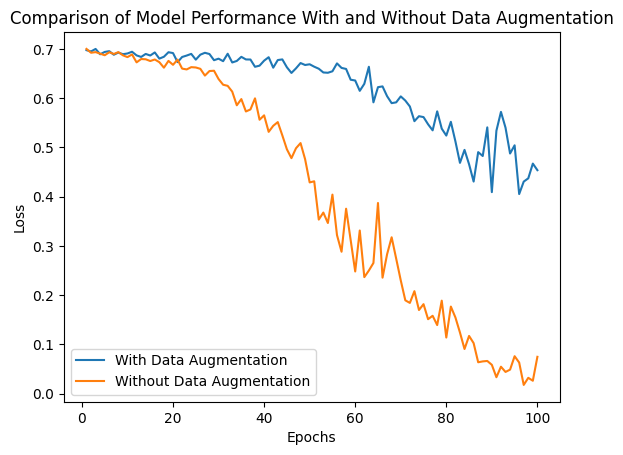

In [ ]:

# Plot initial_losses after the initial training loop
plt.plot(range(1, 100+1), loss_over_epochs, label="With Data Augmentation")
plt.plot(range(1, 100+1), loss_over_epochs_without_aug, label="Without Data Augmentation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Comparison of Model Performance With and Without Data Augmentation")
plt.show()



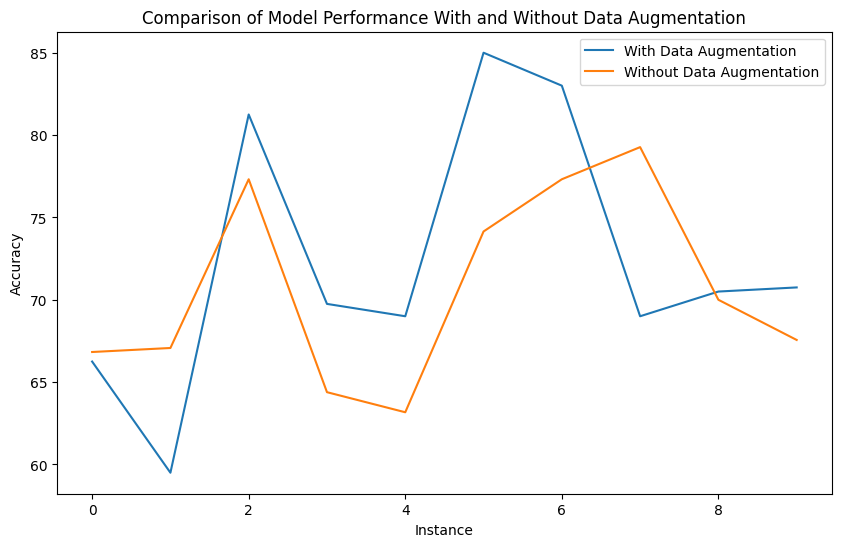

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(accs_with_augmentation, loss_over_epochs_without_aug):
    plt.figure(figsize=(10, 6))
    plt.plot(accs, label="With Data Augmentation")
    plt.plot(accs_no_aug, label="Without Data Augmentation")
    plt.xlabel("Instance")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Comparison of Model Performance With and Without Data Augmentation")
    plt.show()

plot_accuracies(accs, accs_no_aug)


# **Challenge 2**

# **Approach 1**

part 1 : using alexnet

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy

from torch.optim.lr_scheduler import StepLR



def train(model, alexnet, train_loader, optimizer, epoch, device, display=True):
    model.train()
    alexnet.train()
    epoch_losses = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        features = alexnet.features(inputs)
        features = features.view(features.size(0), -1)

        optimizer.zero_grad()
        output = model(features)
        loss = nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.cpu().detach().numpy())

    if display:
        print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))

    return epoch_losses

def test(model,alexnet, device, val_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = alexnet.features(inputs) 
            features = features.view(features.size(0), -1)
            output = model(features)  
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return accuracy


def train_loop(patience,epochs,fine_tuning_lr,fine_tuning_weight_decay,instances):
    # epochs=100
    resize = transforms.Resize((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        resize,
        transforms.ToTensor(),
        normalize
    ])


    transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize])


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    cifar_data = datasets.CIFAR10(root='.', train=True, transform=transform_train, download=True)
    cifar_data_val = datasets.CIFAR10(root='.', train=True, transform=transform_val, download=True)

    alexnet = models.alexnet(pretrained=True)


    alexnet.to(device)

    model = nn.Linear(256 * 6 * 6, 10) 

    accs = []
    accs_before = []
    accs_after = []

    for seed in range(1, instances):
        prng = RandomState(seed)
        random_permute = prng.permutation(np.arange(0, 1000))
        classes = prng.permutation(np.arange(0, 10))
        indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
        indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
        train_data = Subset(cifar_data, indx_train)
        val_data = Subset(cifar_data_val, indx_val)

        print('Num Samples For Training %d Num Samples For Val %d' % (train_data.indices.shape[0], val_data.indices.shape[0]))

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

        train_features = []
        train_labels = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            features = alexnet.features(inputs)
            features = features.view(features.size(0), -1)
            train_features.append(features)
            train_labels.append(labels)
        train_features = torch.cat(train_features)
        train_labels = torch.cat(train_labels)

        model = nn.Linear(256 * 6 * 6, 10)

        model.to(device)
        initial_losses=[]
        optimizer = torch.optim.SGD(model.parameters(), 
                                  lr=0.01, momentum=0.9,
                                  weight_decay=fine_tuning_weight_decay)

        for epoch in range(epochs):
            loss = train(model, alexnet, train_loader, optimizer, epoch, device, display=epoch % 5 == 0)
            initial_losses.append(loss)
        acc_before = test(model,alexnet, device, val_loader)
        accs_before.append(acc_before)

        # Fine-tuning
        for param in alexnet.features.parameters():
            param.requires_grad = False
        for param in alexnet.features[19:].parameters():
            param.requires_grad = True
        
        optimizer = torch.optim.SGD([
            {'params': model.parameters()},
            {'params': alexnet.features[19:].parameters(), 'lr':fine_tuning_lr}
        ], lr=0.01, momentum=0.9, weight_decay=0.0005)

        losses = []
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

        min_val_loss = np.inf
        best_model = None
        epochs_no_improvement = 0
        # patience = 20

        for epoch in range(epochs):
            loss = train(model, alexnet, train_loader, optimizer, epoch, device, display=epoch % 5 == 0)
            losses.append(loss)
            val_accuracy = test(model, alexnet, device, val_loader)
            val_loss = -val_accuracy
            scheduler.step(val_loss)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = deepcopy(model)
                epochs_no_improvement = 0
            else:
                epochs_no_improvement += 1

            if epochs_no_improvement >= patience:
                print("Early stopping")
                break

        model = best_model
        acc_after = test(model, alexnet, device, val_loader)
        accs_after.append(acc_after)

    accs_before = np.array(accs_before)
    accs_after = np.array(accs_after)

    print('mean Acc before fine-tuning: %.2f +- %.2f' % (accs_before.mean(), accs_before.std()))
    print('mean Acc after fine-tuning: %.2f +- %.2f' % (accs_after.mean(), accs_after.std()))
    
    return model,accs_before,accs_after,initial_losses,losses

model,accs_before,accs_after,initial_losses,losses=train_loop(patience=70,epochs=100,fine_tuning_lr=1e-8,fine_tuning_weight_decay=0.00005,instances=5)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 Loss: 2.196516
Train Epoch: 5 Loss: 8.846688
Train Epoch: 10 Loss: 4.979657
Train Epoch: 15 Loss: 2.286589
Train Epoch: 20 Loss: 0.181737
Train Epoch: 25 Loss: 0.793374
Train Epoch: 30 Loss: 0.410373
Train Epoch: 35 Loss: 0.423140
Train Epoch: 40 Loss: 0.537142
Train Epoch: 45 Loss: 0.501998
Train Epoch: 50 Loss: 0.191969
Train Epoch: 55 Loss: 0.282443
Train Epoch: 60 Loss: 2.305186
Train Epoch: 65 Loss: 0.000580
Train Epoch: 70 Loss: 0.231379
Train Epoch: 75 Loss: 0.590459
Train Epoch: 80 Loss: 0.591784
Train Epoch: 85 Loss: 0.159547
Train Epoch: 90 Loss: 0.477419
Train Epoch: 95 Loss: 0.272924
Train Epoch: 0 Loss: 0.490756
Train Epoch: 5 Loss: 0.136988
Train Epoch: 10 Loss: 0.001161
Train Epoch: 15 Loss: 1.144057
Train Epoch: 20 Loss: 0.122752
Train Epoch: 25 Loss: 0.020365
Train Epoch: 30 Loss: 0.142934
Train Epoch: 35 Loss: 0.123715
Train Epoch: 40 Loss: 0.313133
Train Epoch: 45 Loss: 0.321400
Train Epoch: 50 Loss: 

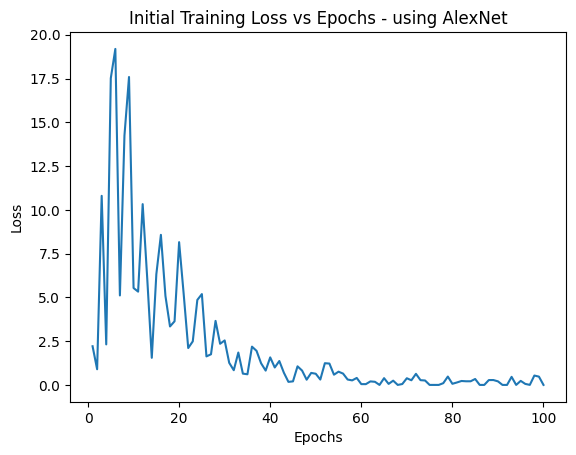

In [ ]:
# Plot initial_losses after the initial training loop
epochs=100
plt.plot(range(1, epochs+1), initial_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Initial Training Loss vs Epochs - using AlexNet')
plt.show()



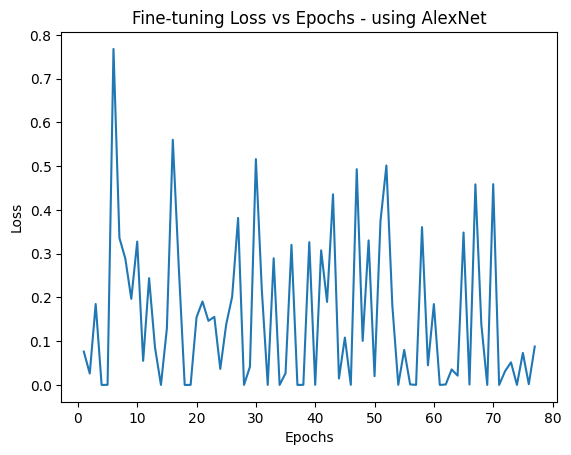

In [ ]:
# Plot losses (for the fine-tuning phase) after the fine-tuning training loop
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss vs Epochs - using AlexNet')
plt.show()

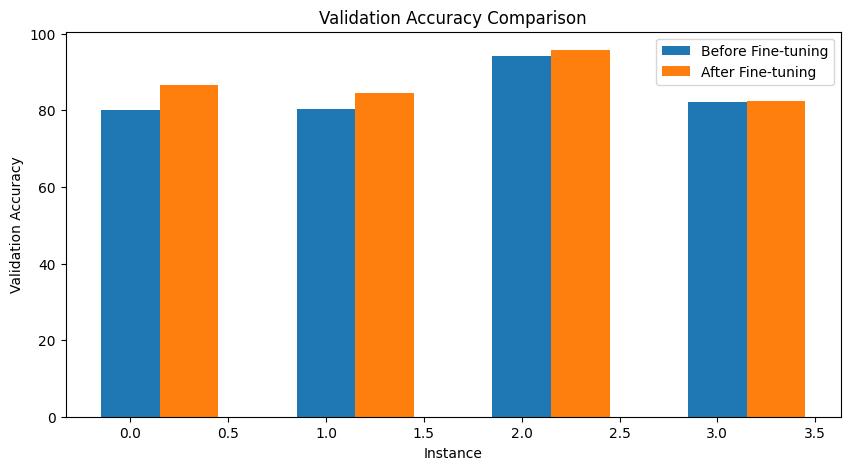

In [ ]:
def plot_accuracy_comparison(accs_before, accs_after):
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(accs_before)), accs_before, width=0.3, label="Before Fine-tuning")
    plt.bar(np.arange(len(accs_after)) + 0.3, accs_after, width=0.3, label="After Fine-tuning")
    plt.xlabel("Instance")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison")
    plt.legend()
    plt.show()
plot_accuracy_comparison(accs_before, accs_after)


**Adjusting hyperparameters for fine-tuning**

In [ ]:


# Hyperparameters for experimentation
weight_decays = [0.005,0.0005,0.00005]
# num_epochs_list = []
patience_list=[20,50]
fine_tuning_lr_list = [1e-3,1e-5,1e-8]
num_epochs=100

results_for_hyperparameters=pd.DataFrame()
accs_before_ft=[]
accs_after_ft=[]
patiences=[]
wd=[]
fine_tuning_lrs=[]
i=0
for weight_decay in weight_decays:
  for patience in patience_list:
    for fine_tuning_lr in fine_tuning_lr_list: 
      print("loop number : ",i)
      i=i+1
      model,acc_before_ft,acc_after_ft,initial_losses,losses=train_loop(patience=patience,epochs=100,fine_tuning_lr=fine_tuning_lr,fine_tuning_weight_decay=weight_decay,instances=2)
      accs_after_ft.append(acc_after_ft)
      accs_before_ft.append(acc_before_ft)
      wd.append(weight_decay)
      patiences.append(patience)
      fine_tuning_lrs.append(fine_tuning_lr)
results_for_hyperparameters['patience']=patiences
results_for_hyperparameters['weight_decay']=wd
results_for_hyperparameters['fine_tuning_lr']=fine_tuning_lrs
results_for_hyperparameters['Accuracy before Fine Tuning']=accs_before_ft
results_for_hyperparameters['Accuracy after Fine Tuning']=accs_after_ft



loop number :  0
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 Loss: 2.668220
Train Epoch: 5 Loss: 18.923853
Train Epoch: 10 Loss: 1.902688
Train Epoch: 15 Loss: 4.784052
Train Epoch: 20 Loss: 2.718896
Train Epoch: 25 Loss: 2.164139
Train Epoch: 30 Loss: 1.009759
Train Epoch: 35 Loss: 1.452230
Train Epoch: 40 Loss: 1.109968
Train Epoch: 45 Loss: 1.579364
Train Epoch: 50 Loss: 0.400162
Train Epoch: 55 Loss: 1.256029
Train Epoch: 60 Loss: 1.147732
Train Epoch: 65 Loss: 0.666672
Train Epoch: 70 Loss: 0.207882
Train Epoch: 75 Loss: 0.559716
Train Epoch: 80 Loss: 0.003752
Train Epoch: 85 Loss: 0.232202
Train Epoch: 90 Loss: 0.290556
Train Epoch: 95 Loss: 0.491432
Train Epoch: 0 Loss: 0.377328
Train Epoch: 5 Loss: 1.182039
Train Epoch: 10 Loss: 0.215103
Train Epoch: 15 Loss: 0.503771
Epoch 00017: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00017: reducing learning rate of group 1 to 5.0000e-04.
Train Epoch: 20 Loss: 0.193271
Train Epoch: 25 Loss: 0.369489
Epoch 00028: reducing

In [ ]:
results_for_hyperparameters['improvement by fine-tuning']=results_for_hyperparameters['Accuracy after Fine Tuning']-results_for_hyperparameters['Accuracy before Fine Tuning']

sorted_df = results_for_hyperparameters.sort_values(["improvement by fine-tuning"], ascending=[False])
sorted_df.head(10)


,patience,weight_decay,fine_tuning_lr,Accuracy before Fine Tuning,Accuracy after Fine Tuning,improvement by fine-tuning
5,50,0.00500,1.000000e-08,[76.5],[85.0],[8.5]
10,50,0.00050,1.000000e-05,[77.25],[84.75],[7.5]
7,20,0.00050,1.000000e-05,[78.75],[85.25],[6.5]
17,50,0.00005,1.000000e-08,[81.25],[87.0],[5.75]
0,20,0.00500,1.000000e-03,[83.75],[87.75],[4.0]
16,50,0.00005,1.000000e-05,[83.5],[86.5],[3.0]
11,50,0.00050,1.000000e-08,[81.0],[82.75],[1.75]
14,20,0.00005,1.000000e-08,[83.0],[84.5],[1.5]
9,50,0.00050,1.000000e-03,[84.0],[85.5],[1.5]
2,20,0.00500,1.000000e-08,[85.75],[87.0],[1.25]


**Using VGG16**

In [ ]:

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])


transform_val = transforms.Compose([transforms.ToTensor(), normalize])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load CIFAR10 dataset
cifar_data = datasets.CIFAR10(root='.', train=True, transform=transform_train, download=True)
cifar_data_val = datasets.CIFAR10(root='.', train=True, transform=transform_val, download=True)

# Load the VGG16 model pre-trained on ImageNet
vgg16 = models.vgg16(pretrained=True)
# Remove the classifier part of the VGG16 model
vgg16_features = vgg16.features
vgg16_features.to(device)

class SmallClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def train(model, train_features, train_labels, optimizer, epoch, display=True):
    train_features, train_labels = torch.tensor(train_features).to(device), torch.tensor(train_labels).to(device)
    model.train()
    optimizer.zero_grad()
    output = model(train_features)
    loss = nn.CrossEntropyLoss()(output, train_labels)
    loss.backward()
    optimizer.step()
    if display:
        print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
    return loss.item()



def test(model, device, val_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            features = vgg16_features(inputs)
            features = features.view(features.size(0), -1)
            output = model(features)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(val_loader.dataset), accuracy))
    return accuracy


accs = []
accs_before = []
accs_after = []


for seed in range(1, 5):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes = prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data_val, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d' % (train_data.indices.shape[0], val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = SmallClassifier()
    model.to(device)

    # Extract bottleneck features from VGG16 model
    train_features = []
    train_labels = []
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = vgg16_features(inputs)
        features = features.view(features.size(0), -1)
        train_features.append(features)
        train_labels.append(labels)
    train_features = torch.cat(train_features)
    train_labels = torch.cat(train_labels)
    initial_losses = []
    # Train the small fully-connected model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
    for epoch in range(100):
        loss = train(model, train_features, train_labels, optimizer, epoch, display=epoch % 5 == 0)
        initial_losses.append(loss)

    acc_before = test(model, device, val_loader)
    accs_before.append(acc_before)

    # Fine-tuning
    # Freeze all layers except the last convolutional block
    for param in vgg16_features.parameters():
        param.requires_grad = False
    for param in vgg16_features[24:].parameters():
        param.requires_grad = True

    # Train the fine-tuned model
    optimizer = torch.optim.SGD([
        {'params': model.parameters()},
        {'params': vgg16_features[24:].parameters(), 'lr': 1e-8}
    ], lr=1e-3, momentum=0.9, weight_decay=0.005)

    losses = []
    for epoch in range(100):
        loss = train(model, train_features, train_labels, optimizer, epoch, display=epoch % 5 == 0)
        losses.append(loss)

    acc_after = test(model, device, val_loader)
    accs_after.append(acc_after)

accs_after = np.array(accs_after)
accs_before = np.array(accs_before)
print('mean Acc before fine-tuning: %.2f +- %.2f' % (accs_before.mean(), accs_before.std()))
print('mean Acc after fine-tuning: %.2f +- %.2f' % (accs_after.mean(), accs_after.std()))

Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 Loss: 2.464697
Train Epoch: 5 Loss: 0.934392
Train Epoch: 10 Loss: 0.503412
Train Epoch: 15 Loss: 0.376784
Train Epoch: 20 Loss: 0.296854
Train Epoch: 25 Loss: 0.165091
Train Epoch: 30 Loss: 0.213557
Train Epoch: 35 Loss: 0.104720
Train Epoch: 40 Loss: 0.059804
Train Epoch: 45 Loss: 0.029294
Train Epoch: 50 Loss: 0.027672
Train Epoch: 55 Loss: 0.013773
Train Epoch: 60 Loss: 0.020157
Train Epoch: 65 Loss: 0.009993
Train Epoch: 70 Loss: 0.015200
Train Epoch: 75 Loss: 0.014121
Train Epoch: 80 Loss: 0.008259
Train Epoch: 85 Loss: 0.007224
Train Epoch: 90 Loss: 0.003593
Train Epoch: 95 Loss: 0.028287


<ipython-input-179-b7ab3ef29ccf>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features, train_labels = torch.tensor(train_features).to(device), torch.tensor(train_labels).to(device)


Test set: Average loss: 1.1622, Accuracy: 278/400 (70%)
Train Epoch: 0 Loss: 0.011495
Train Epoch: 5 Loss: 0.013229
Train Epoch: 10 Loss: 0.005531
Train Epoch: 15 Loss: 0.012603
Train Epoch: 20 Loss: 0.004859
Train Epoch: 25 Loss: 0.004429
Train Epoch: 30 Loss: 0.005266
Train Epoch: 35 Loss: 0.005254
Train Epoch: 40 Loss: 0.006735
Train Epoch: 45 Loss: 0.005885
Train Epoch: 50 Loss: 0.004444
Train Epoch: 55 Loss: 0.004022
Train Epoch: 60 Loss: 0.010052
Train Epoch: 65 Loss: 0.008435
Train Epoch: 70 Loss: 0.004228
Train Epoch: 75 Loss: 0.012946
Train Epoch: 80 Loss: 0.010257
Train Epoch: 85 Loss: 0.004142
Train Epoch: 90 Loss: 0.002268
Train Epoch: 95 Loss: 0.007282
Test set: Average loss: 1.1681, Accuracy: 278/400 (70%)
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 Loss: 2.454131
Train Epoch: 5 Loss: 1.229168
Train Epoch: 10 Loss: 0.434040
Train Epoch: 15 Loss: 0.309393
Train Epoch: 20 Loss: 0.340649
Train Epoch: 25 Loss: 0.221536
Train Epoch: 30 Loss: 0.116879
Tra

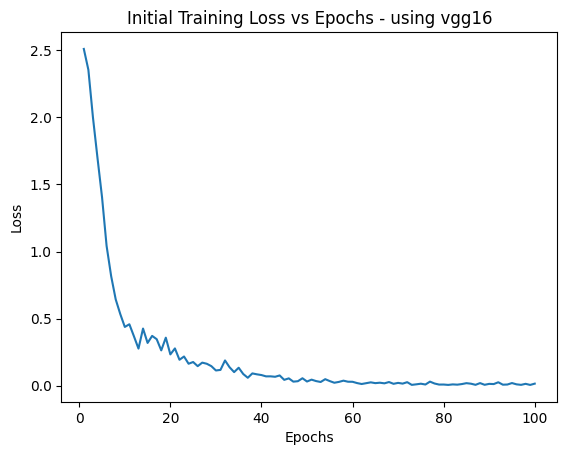

In [ ]:
# Plot initial_losses after the initial training loop
plt.plot(range(1, 101), initial_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Initial Training Loss vs Epochs - using vgg16')
plt.show()



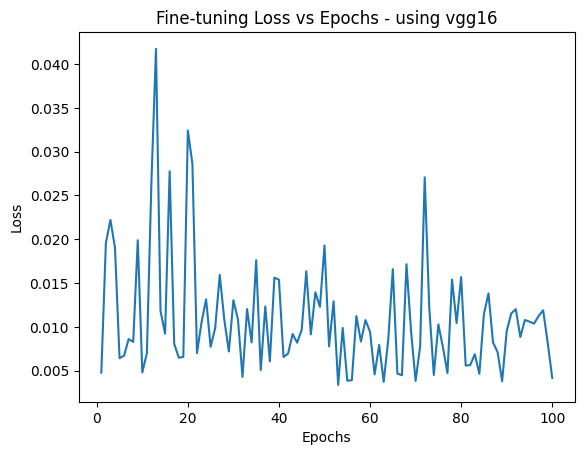

In [ ]:

# Plot losses (for the fine-tuning phase) after the fine-tuning training loop
plt.plot(range(1, 101), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss vs Epochs - using vgg16')
plt.show()

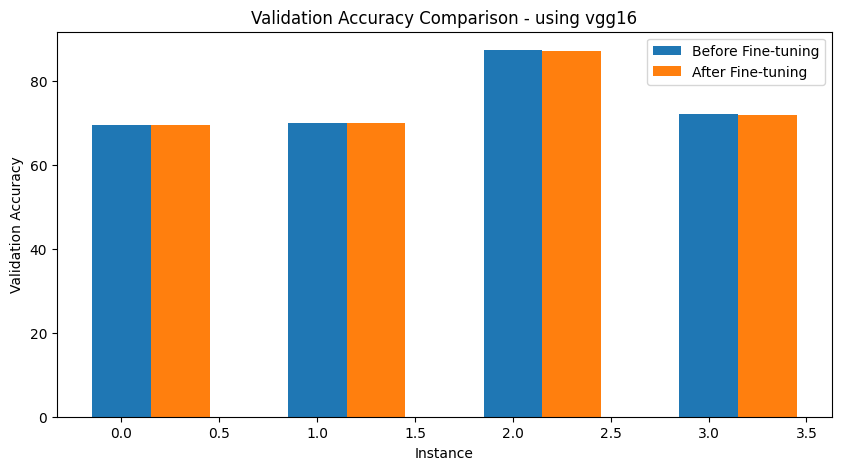

In [ ]:
def plot_accuracy_comparison(accs_before, accs_after):
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(accs_before)), accs_before, width=0.3, label="Before Fine-tuning")
    plt.bar(np.arange(len(accs_after)) + 0.3, accs_after, width=0.3, label="After Fine-tuning")
    plt.xlabel("Instance")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison - using vgg16")
    plt.legend()
    plt.show()
plot_accuracy_comparison(accs_before, accs_after)

Validating: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

Validation Accuracy: 0.5000


# **Approach 2**
Relation networks


In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())

    def forward(self,x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = out.view(out.size(0),-1)
        return out # 64

In [ ]:

class RelationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(input_size, hidden_size)  # Keep the input size as a variable
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # print("Output size before FC layer:", out.shape)  # Print the output size
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.sigmoid(self.fc2(out))
        return out


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        n = m.weight.size(1)
        m.weight.data.normal_(0, 0.01)
        m.bias.data = torch.ones(m.bias.data.size())

In [ ]:
import scipy as sp
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m,h

In [ ]:
import random
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)


support_samples_per_class=5
query_samples_per_class=20
num_classes=2
selected_classes = random.sample(range(10), num_classes)
def create_few_shot_dataset(dataset, num_classes=2, support_samples_per_class=5, query_samples_per_class=20):
    class_counts = {}
    support_indices = []
    query_indices = []
    

    for idx, (img, label) in enumerate(dataset):
        if label not in selected_classes:
            continue

        if label not in class_counts:
            class_counts[label] = 0

        if class_counts[label] < support_samples_per_class + query_samples_per_class:
            if class_counts[label] < support_samples_per_class:
                support_indices.append(idx)
            else:
                query_indices.append(idx)
            class_counts[label] += 1

        if len(class_counts) == num_classes and all(count == support_samples_per_class + query_samples_per_class for count in class_counts.values()):
            break

    return support_indices, query_indices

# Create few-shot dataset
support_indices, query_indices = create_few_shot_dataset(cifar_data)

# Create Subset for support and query sets
support_subset = Subset(cifar_data, support_indices)
query_subset = Subset(cifar_data_val, query_indices)  # Use cifar_data_val with transform_val

# Create DataLoaders
support_loader = DataLoader(support_subset, batch_size=support_samples_per_class*num_classes, shuffle=True)
query_loader = DataLoader(query_subset, batch_size=query_samples_per_class*num_classes, shuffle=True)



100%|██████████| 170498071/170498071 [00:02<00:00, 70033766.36it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
device="cpu"
# Training and testing loop

from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import math 

FEATURE_DIM = 64
RELATION_DIM = 8
CLASS_NUM = 2
SAMPLE_NUM_PER_CLASS = 25
BATCH_NUM_PER_CLASS = 50
EPISODE = 500000
TEST_EPISODE =600
HIDDEN_UNIT = 10
LEARNING_RATE=0.01

feature_encoder = CNNEncoder() #an embedding module f'
relation_network = RelationNetwork(FEATURE_DIM,RELATION_DIM) #a relation module g

feature_encoder.apply(weights_init)
relation_network.apply(weights_init)

feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=LEARNING_RATE)
feature_encoder_scheduler = StepLR(feature_encoder_optim,step_size=100000,gamma=0.5)
relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=LEARNING_RATE)
relation_network_scheduler = StepLR(relation_network_optim,step_size=100000,gamma=0.5)

mse = nn.MSELoss()

num_epochs = 100  # Adjust this value based on your needs

for epoch in range(num_epochs):
    running_loss = 0.0
    
    support_samples, support_labels = next(iter(support_loader))
    query_samples, query_labels = next(iter(query_loader))
    
    support_samples, support_labels = support_samples.to(device), support_labels.to(device)
    query_samples, query_labels = query_samples.to(device), query_labels.to(device)
    
    feature_encoder.zero_grad()
    relation_network.zero_grad()
    feature_encoder.to(device)
    relation_network.to(device)
    support_features = feature_encoder(support_samples)
    support_features = support_features.view(CLASS_NUM, support_samples_per_class, FEATURE_DIM, 6, 6)
    support_features = torch.sum(support_features, 1).squeeze(1)
    
    query_features = feature_encoder(query_samples)
    
    support_features_ext = support_features.unsqueeze(0).repeat(query_samples_per_class * CLASS_NUM, 1, 1, 1, 1)
    query_features_ext = query_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
    query_features_ext = torch.transpose(query_features_ext, 0, 1)
    
    relation_pairs = torch.cat((support_features_ext, query_features_ext), 2).view(-1, FEATURE_DIM * 2, 6, 6)
    relations = relation_network(relation_pairs).view(-1, CLASS_NUM)
    
    query_labels_indices = torch.tensor([selected_classes.index(x.item()) for x in query_labels], dtype=torch.long, device=device)
    one_hot_labels = torch.zeros(relations.shape[0], CLASS_NUM, device=device).scatter_(1, query_labels.view(-1, 1).cpu().apply_(lambda x: selected_classes.index(x)).to(device), 1)



    loss = mse(relations, one_hot_labels)
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)
    
    feature_encoder_optim.step()
    relation_network_optim.step()

    running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss}")


<ipython-input-10-82ed441f3a53>:68: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
<ipython-input-10-82ed441f3a53>:69: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)


Epoch 1, Loss: 0.30265572667121887
Epoch 2, Loss: 0.2900117039680481
Epoch 3, Loss: 0.2716960608959198
Epoch 4, Loss: 0.25307098031044006
Epoch 5, Loss: 0.2584097981452942
Epoch 6, Loss: 0.26218143105506897
Epoch 7, Loss: 0.2526581883430481
Epoch 8, Loss: 0.2506047785282135
Epoch 9, Loss: 0.25199586153030396
Epoch 10, Loss: 0.25194159150123596
Epoch 11, Loss: 0.2509930729866028
Epoch 12, Loss: 0.25035279989242554
Epoch 13, Loss: 0.25012436509132385
Epoch 14, Loss: 0.2506345808506012
Epoch 15, Loss: 0.25076723098754883
Epoch 16, Loss: 0.25044524669647217
Epoch 17, Loss: 0.250167578458786
Epoch 18, Loss: 0.2500627636909485
Epoch 19, Loss: 0.2502337396144867
Epoch 20, Loss: 0.2503882944583893
Epoch 21, Loss: 0.25044897198677063
Epoch 22, Loss: 0.25020819902420044
Epoch 23, Loss: 0.2500057816505432
Epoch 24, Loss: 0.2500608563423157
Epoch 25, Loss: 0.25020354986190796
Epoch 26, Loss: 0.250190794467926
Epoch 27, Loss: 0.25016531348228455
Epoch 28, Loss: 0.25003185868263245
Epoch 29, Loss: 0